# 言語処理100本ノック 2020 第９章

Reference: https://nlp100.github.io/ja/ch09.html

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

## 80. ID番号への変換

問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

※ gensimですでに実装されているので割愛。

In [2]:
from nltk.tokenize import word_tokenize
from gensim import corpora
from sklearn.preprocessing import OneHotEncoder

In [3]:
train = pd.read_csv("NewsAggregatorDataset/train.txt", sep="\t")
test = pd.read_csv("NewsAggregatorDataset/test.txt", sep="\t")
valid = pd.read_csv("NewsAggregatorDataset/valid.txt", sep="\t")

In [14]:
# Tokenize
tokens = [word_tokenize(text) for text in train.TITLE]
# Remove (i) numbers, (ii) single-character words
tokens = [[t for t in token if (not t.isnumeric()) and (len(t) > 1)] for token in tokens]
# Create dictionary
dictionary = corpora.Dictionary(tokens)
print(dictionary)

# Filter out words that occur less than 10 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
print(dictionary)

Dictionary(19395 unique tokens: ['In', 'Labeouf', 'Rehab', 'Report', 'Shia']...)
Dictionary(805 unique tokens: ['In', 'Report', 'Shia', "'s", 'Microsoft']...)


In [78]:
# 0: padded 
# 1: out-of-dictionary
# 2-: words
def text2idx(text, dictionary=dictionary):
    token = word_tokenize(text)
    return(torch.tensor(dictionary.doc2idx(token)) + 2)

In [77]:
text2idx(train.TITLE[1])

tensor([7, 1, 1, 1, 8, 6, 5, 1, 1, 9, 1, 1])

## 81. RNNによる予測
ID番号で表現された単語列x=(x1,x2,…,xT)がある．ただし，Tは単語列の長さ，xt∈ℝVは単語のID番号のone-hot表記である（Vは単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列xからカテゴリyを予測するモデルとして，次式を実装せよ．

なお，この問題ではパラメータの学習を行わず，ランダムに初期化されたパラメータでyを計算するだけでよい．次元数などのハイパーパラメータは，dw=300,dh=50など，適当な値に設定せよ（以降の問題でも同様である）．

In [44]:
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

torch.manual_seed(123) # torch用の乱数シード
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [138]:
class RNN(nn.Module):
    def __init__(self, num_words, hidden_dim):
        super().__init__()
        self.emb = nn.Embedding(num_words, hidden_dim, padding_idx=0)
        self.l1 = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.l2 = nn.Linear(hidden_dim, 4)
        self.sm = nn.Softmax(dim=1)
        nn.init.xavier_normal_(self.l1.weight_ih_l0)
        nn.init.orthogonal_(self.l1.weight_hh_l0)
    def forward(self, x): # x: [batch_size, sequence length, dimension]
        h = self.emb(x)
        h, _ = self.l1(h)
        y = self.l2(h[:, -1])
        y = self.sm(y)
        return y

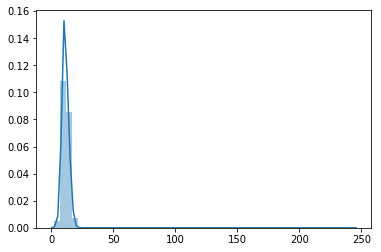

In [161]:
word_size = [len(text2idx(text)) for text in train.TITLE]
import seaborn as sns
sns.distplot(word_size)

In [162]:
x_train = [text2idx(text)[:25] for text in train.TITLE]

# padding: 配列長を揃える
# batch_first=True -> returns [batch_size, sequence length, dimension]
x_train = pad_sequence(x_train, batch_first=True) 
x_train[:2]

tensor([[4, 1, 1, 4, 1, 2, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [7, 1, 1, 1, 8, 6, 5, 1, 1, 9, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])

In [163]:
model = RNN(num_words=len(dictionary)+2, hidden_dim=50).to(device) # set dimension of hidden layers as 50
res = model.forward(x_train)
res

tensor([[0.2445, 0.3312, 0.2200, 0.2043],
        [0.2413, 0.3042, 0.2531, 0.2015],
        [0.2368, 0.3173, 0.2234, 0.2225],
        ...,
        [0.2426, 0.3229, 0.2347, 0.1999],
        [0.2365, 0.3260, 0.2240, 0.2135],
        [0.2534, 0.3056, 0.2396, 0.2014]], grad_fn=<SoftmaxBackward>)

## 82. 確率的勾配降下法による学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

## 83. ミニバッチ化・GPU上での学習

問題82のコードを改変し，B
事例ごとに損失・勾配を計算して学習を行えるようにせよ（Bの値は適当に選べ）．また，GPU上で学習を実行せよ．

In [164]:
from sklearn.metrics import accuracy_score

In [165]:
#b = business, t = science and technology, e = entertainment, m = health
y = np.identity(4).astype(int)
y_dict = {"b":0, "t":1, "e":2, "m":3}
y_train = [y_dict[c] for c in train.CATEGORY]
y_test = [y_dict[c] for c in test.CATEGORY]
y_valid = [y_dict[c] for c in valid.CATEGORY]
y_train[:5]

[2, 1, 2, 2, 3]

In [166]:
# Model
model = RNN(num_words=len(dictionary)+2, hidden_dim=50).to(device) 

# Optimmizer
optimizer = optimizers.SGD(model.parameters(), lr=0.1)

# Dataset
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.Tensor(y).long().to(device)
        self.transform = transform
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        x_out = self.x[idx]
        y_out = self.y[idx]
        if self.transform:
            x_out = self.transform(x_out)
        return x_out, y_out
train_dataset = TestDataset(x_train, y_train)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

# Loss 
loss_function = nn.CrossEntropyLoss()

# Training step
def train_step(x, t):
    model.train()
    preds = model(x)
    loss = loss_function(preds, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds 

In [167]:
epochs = 10
for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.
    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=1).tolist())
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print('epoch: {}, loss: {:.3}, acc: {:.3f}'.format(epoch+1, train_loss, train_acc ))

epoch: 1, loss: 1.29, acc: 0.397
epoch: 2, loss: 1.25, acc: 0.475
epoch: 3, loss: 1.2, acc: 0.535
epoch: 4, loss: 1.19, acc: 0.553
epoch: 5, loss: 1.17, acc: 0.572
epoch: 6, loss: 1.16, acc: 0.577
epoch: 7, loss: 1.15, acc: 0.594
epoch: 8, loss: 1.13, acc: 0.606
epoch: 9, loss: 1.12, acc: 0.615
epoch: 10, loss: 1.12, acc: 0.621


## 84. 単語ベクトルの導入

事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込みemb(x)を初期化し，学習せよ．

In [168]:
from gensim.models import KeyedVectors
ifile = "GoogleNews-vectors-negative300.bin.gz"
embeddings_index = KeyedVectors.load_word2vec_format(ifile, binary=True)

/Users/maruyamatooru/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [174]:
embeddings_index.word_vec("</s>")

array([ 1.1291504e-03, -8.9645386e-04,  3.1852722e-04,  1.5335083e-03,
        1.1062622e-03, -1.4038086e-03, -3.0517578e-05, -4.1961670e-04,
       -5.7601929e-04,  1.0757446e-03, -1.0223389e-03, -6.1798096e-04,
       -7.5531006e-04,  1.4038086e-03, -1.6403198e-03, -6.3323975e-04,
        1.6326904e-03, -1.0070801e-03, -1.2664795e-03,  6.5231323e-04,
       -4.1580200e-04, -1.0757446e-03,  1.5258789e-03, -2.7465820e-04,
        1.4019012e-04,  1.5716553e-03,  1.3580322e-03, -8.3160400e-04,
       -1.4038086e-03,  1.5792847e-03,  2.5367737e-04, -7.3242188e-04,
       -1.0538101e-04, -1.1672974e-03,  1.5792847e-03,  6.5612793e-04,
       -6.5994263e-04,  2.9206276e-06,  1.1291504e-03,  4.2724609e-04,
       -3.7002563e-04, -1.1520386e-03,  1.2664795e-03, -3.5166740e-06,
        2.6512146e-04, -4.0245056e-04,  1.4114380e-04, -3.3617020e-05,
        7.5912476e-04, -5.1879883e-04, -7.1048737e-05,  6.0272217e-04,
       -5.0735474e-04, -1.6250610e-03, -4.3678284e-04, -9.9182129e-04,
      

In [173]:
embeddings_index.index2word[:10]

['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']